#Descrição: Codigo criacao de modelos e analise exploratoria PicPay 
#Data: 14-04-2021 
#Versão: 1 
#Desenvolvedor: Kaio Alves Chaves

In [74]:
# !pip -q install boto3
# !pip -q install s3fs
# !pip -q install smart_open


ERROR: aiobotocore 1.3.0 has requirement botocore<1.20.50,>=1.20.49, but you'll have botocore 1.20.51 which is incompatible.
ERROR: boto3 1.17.51 has requirement botocore<1.21.0,>=1.20.51, but you'll have botocore 1.20.49 which is incompatible.


In [309]:
import requests
import pandas as pd
from base64 import b64encode, b64decode
from smart_open import smart_open
import os
import boto3
from s3fs.core import S3FileSystem
import configparser
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import numpy as np

Carregando informções do Bucket Cleaned da arquitetura S3

In [78]:
BUCKET_NAME = 'picpay-bucket-kaio-cleaned' 

s3 = boto3.resource('s3', aws_access_key_id = 'XXXXXXXXXXXXXXXXXX', 
                          aws_secret_access_key= 'XXXXXXXXXXXXXXXXXX')

In [323]:

bucket = s3.Bucket(BUCKET_NAME)

for obj in bucket.objects.all():
      key = obj.key
      print
      body = obj.get()['Body'].read()
      lista = body.splitlines()
      for a in lista:
        indice =lista.index(a)
        if indice  > 0: 
          s3_df=df.append({'id' : a[0] ,
            'name' : a[1],
            'abv' : a[2],
            'ibu' : a[3],
            'target_fg' : a[4],
            'target_og' : a[5],
            'ebc' : a[6],
            'srm' : a[7],
            'ph' : a[8]}, ignore_index=True)
    
s3_df.to_csv('treina_model_s3.csv')
s3_df

  


    


,id,name,abv,ibu,target_fg,target_og,ebc,srm,ph
0,77,Hobo Pop,4.2,50,1010,1042,30,15,4.4
1,5,Avery Brown Dredge,7.2,59,1027,1069,10,5,4.4
2,289,Hello My Name Is Lieke,8.2,70,1009,1070,15,8,4.4
3,250,Small Batch: Rye IPA,7.2,100,1010,1065,8,16,4.4
4,243,Gin Blitz,3.2,8,1008,1038,8,4,3.2
...,...,...,...,...,...,...,...,...,...
997,201,Waimea - IPA Is Dead,6.7,70,1015,1066,30,15,4.4
998,179,How To Disappear Completely,3.5,198,1010,1037,37,19,4.4
999,105,Hello My Name Is Beastie,8.2,42,1013,1078,90,45,4.4
1000,38,Belgian Trappist,6.3,55,1012,1060,30,15,4.4


Gerando Base de treino Via API PUNKAPI

In [44]:

cols = ['id','name','abv','ibu','target_fg','target_og','ebc','srm','ph']


df = pd.DataFrame(columns=cols)

for i in range(1001):
    requisitado = 'https://api.punkapi.com/v2/beers/random'
    requisitado_info = requests.get(requisitado)
    requisitado_json = requisitado_info.json()
    requisitado_json_fora = requisitado_json[0]
    df=df.append({'id' : requisitado_json_fora['id'] ,
                  'name' : requisitado_json_fora['name'],
                  'abv' : requisitado_json_fora['abv'],
                  'ibu' : requisitado_json_fora['ibu'],
                  'target_fg' : requisitado_json_fora['target_fg'],
                  'target_og' : requisitado_json_fora['target_og'],
                  'ebc' : requisitado_json_fora['ebc'],
                  'srm' : requisitado_json_fora['srm'],
                  'ph' : requisitado_json_fora['ph']}, ignore_index=True)
    
df.to_csv('treina_model.csv')

  







Preparacao e análise exploratória 

In [46]:
df_base_modelo = pd.read_csv('treina_model.csv')


In [54]:
df_base_modelo=df_base_modelo.sort_values('id')
print(df_base_modelo.columns)
print(df_base_modelo.shape)

Index(['Unnamed: 0', 'id', 'name', 'abv', 'ibu', 'target_fg', 'target_og',
       'ebc', 'srm', 'ph'],
      dtype='object')
(1001, 10)


In [59]:
print(df_base_modelo)
result_df = df_base_modelo.drop_duplicates(subset=['id'], keep='first')
print(result_df)

     Unnamed: 0   id     name  abv   ibu  target_fg  target_og   ebc   srm   ph
781         781    1     Buzz  4.5  60.0       1010     1044.0  20.0  10.0  4.4
75           75    1     Buzz  4.5  60.0       1010     1044.0  20.0  10.0  4.4
618         618    1     Buzz  4.5  60.0       1010     1044.0  20.0  10.0  4.4
718         718    1     Buzz  4.5  60.0       1010     1044.0  20.0  10.0  4.4
952         952    1     Buzz  4.5  60.0       1010     1044.0  20.0  10.0  4.4
..          ...  ...      ...  ...   ...        ...        ...   ...   ...  ...
144         144  325  Zipcode  5.0  37.0       1006     1044.0   5.0   3.0  4.4
930         930  325  Zipcode  5.0  37.0       1006     1044.0   5.0   3.0  4.4
615         615  325  Zipcode  5.0  37.0       1006     1044.0   5.0   3.0  4.4
398         398  325  Zipcode  5.0  37.0       1006     1044.0   5.0   3.0  4.4
562         562  325  Zipcode  5.0  37.0       1006     1044.0   5.0   3.0  4.4

[1001 rows x 10 columns]
     Unnamed: 

In [62]:
result_df.dtypes

Unnamed: 0      int64
id              int64
name           object
abv           float64
ibu           float64
target_fg       int64
target_og     float64
ebc           float64
srm           float64
ph            float64
dtype: object

In [72]:
for con in cols:
  print('Na coluna ' + str(con) + ' há ' + str(result_df[con].isnull().sum()) + ' Nulos ')

print('##########################')
result_df_limpo = result_df.dropna()

for con in cols:
  print('Na coluna ' + str(con) + ' há ' + str(result_df_limpo[con].isnull().sum()) + ' Nulos ')



Na coluna id há 0 Nulos 
Na coluna name há 0 Nulos 
Na coluna abv há 0 Nulos 
Na coluna ibu há 3 Nulos 
Na coluna target_fg há 0 Nulos 
Na coluna target_og há 0 Nulos 
Na coluna ebc há 4 Nulos 
Na coluna srm há 4 Nulos 
Na coluna ph há 1 Nulos 
##########################
Na coluna id há 0 Nulos 
Na coluna name há 0 Nulos 
Na coluna abv há 0 Nulos 
Na coluna ibu há 0 Nulos 
Na coluna target_fg há 0 Nulos 
Na coluna target_og há 0 Nulos 
Na coluna ebc há 0 Nulos 
Na coluna srm há 0 Nulos 
Na coluna ph há 0 Nulos 


In [73]:
result_df_limpo.describe()

,Unnamed: 0,id,abv,ibu,target_fg,target_og,ebc,srm,ph
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.00000,306.00000
mean,515.098039,163.349673,7.778105,65.732026,1015.176471,1067.643464,66.947386,33.70098,4.66732
std,285.989287,94.012618,3.922984,94.011972,13.963239,27.175308,93.518680,47.15671,4.27741
min,0.000000,1.000000,0.500000,0.000000,1000.000000,1007.000000,2.000000,1.00000,3.20000
25%,280.500000,83.250000,5.200000,35.000000,1010.000000,1048.625000,15.000000,8.00000,4.40000
50%,518.000000,163.500000,7.200000,50.000000,1012.000000,1065.000000,29.000000,15.00000,4.40000
75%,745.000000,244.750000,9.000000,70.000000,1015.000000,1080.000000,76.850000,39.00000,4.40000
max,999.000000,325.000000,41.000000,1157.000000,1125.000000,1157.000000,600.000000,305.00000,79.00000


In [199]:
correlacao=result_df_limpo.corr()
correlacao[['abv','ibu','target_fg','target_og','ebc','srm','ph']]


,abv,ibu,target_fg,target_og,ebc,srm,ph
Unnamed: 0,0.065967,-0.004735,0.012679,0.022956,-0.025111,-0.026119,0.091554
id,-0.011673,-0.004788,0.014826,-0.017041,0.022148,0.025548,0.088157
abv,1.000000,0.625113,0.258479,0.727743,0.408226,0.409166,0.024797
ibu,0.625113,1.000000,0.052879,0.247697,0.122422,0.123574,0.004479
target_fg,0.258479,0.052879,1.000000,-0.093918,0.357932,0.357456,0.005262
target_og,0.727743,0.247697,-0.093918,1.000000,0.449176,0.449988,0.047349
ebc,0.408226,0.122422,0.357932,0.449176,1.000000,0.999598,-0.016435
srm,0.409166,0.123574,0.357456,0.449988,0.999598,1.000000,-0.015945
ph,0.024797,0.004479,0.005262,0.047349,-0.016435,-0.015945,1.000000


(array([ 45., 181.,  51.,  23.,   4.,   0.,   0.,   1.,   0.,   1.]),
 array([ 0.5 ,  4.55,  8.6 , 12.65, 16.7 , 20.75, 24.8 , 28.85, 32.9 ,
        36.95, 41.  ]),
 <a list of 10 Patch objects>)

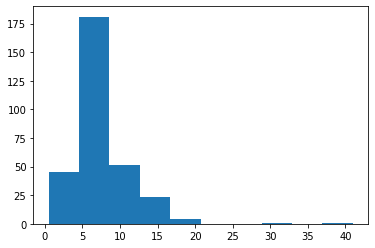

In [205]:
plt.hist(result_df_limpo['abv'])


(array([291.,   7.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([   0. ,  115.7,  231.4,  347.1,  462.8,  578.5,  694.2,  809.9,
         925.6, 1041.3, 1157. ]),
 <a list of 10 Patch objects>)

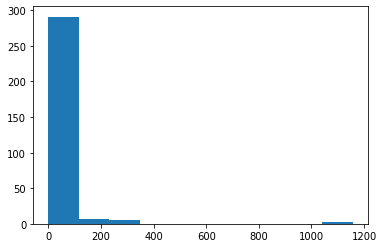

In [206]:
plt.hist(result_df_limpo['ibu'])


(array([171., 108.,  14.,   6.,   0.,   3.,   1.,   0.,   1.,   2.]),
 array([1000. , 1012.5, 1025. , 1037.5, 1050. , 1062.5, 1075. , 1087.5,
        1100. , 1112.5, 1125. ]),
 <a list of 10 Patch objects>)

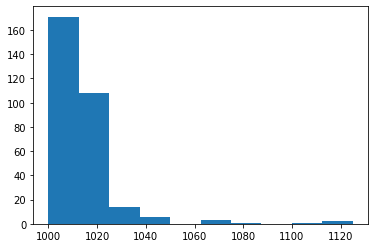

In [207]:
plt.hist(result_df_limpo['target_fg'])


(array([13.,  7., 68., 73., 74., 30., 15., 17.,  5.,  4.]),
 array([1007., 1022., 1037., 1052., 1067., 1082., 1097., 1112., 1127.,
        1142., 1157.]),
 <a list of 10 Patch objects>)

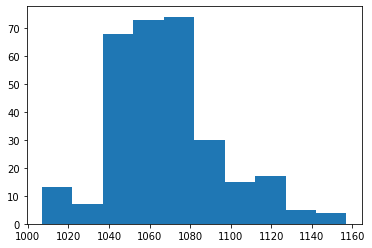

In [208]:
plt.hist(result_df_limpo['target_og'])


(array([222.,  33.,  15.,  16.,  12.,   0.,   5.,   0.,   2.,   1.]),
 array([  2. ,  61.8, 121.6, 181.4, 241.2, 301. , 360.8, 420.6, 480.4,
        540.2, 600. ]),
 <a list of 10 Patch objects>)

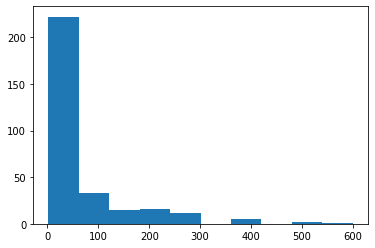

In [209]:
plt.hist(result_df_limpo['ebc'])


(array([223.,  32.,  15.,  16.,  12.,   0.,   5.,   0.,   2.,   1.]),
 array([  1. ,  31.4,  61.8,  92.2, 122.6, 153. , 183.4, 213.8, 244.2,
        274.6, 305. ]),
 <a list of 10 Patch objects>)

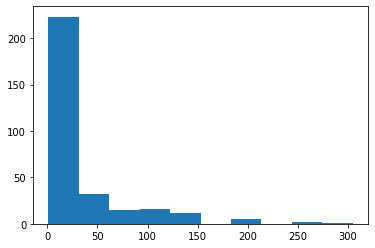

In [210]:
plt.hist(result_df_limpo['srm'])


(array([305.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 3.2 , 10.78, 18.36, 25.94, 33.52, 41.1 , 48.68, 56.26, 63.84,
        71.42, 79.  ]),
 <a list of 10 Patch objects>)

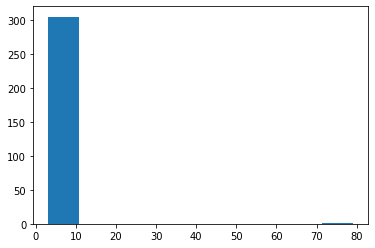

In [211]:
plt.hist(result_df_limpo['ph'])

In [218]:
df_limpo_menor = pd.DataFrame(columns=['id','abv','ibu','target_fg','target_og','ebc','srm','ph'])
for col in ['id','abv','ibu','target_fg','target_og','ebc','srm','ph']:
  df_limpo_menor[col]=pd.to_numeric(result_df_limpo[col])


In [219]:
df_limpo_menor

,id,abv,ibu,target_fg,target_og,ebc,srm,ph
781,1,4.5,60.0,1010,1044.0,20.0,10.0,4.4
458,2,4.1,41.5,1010,1041.7,15.0,15.0,4.4
643,3,4.2,8.0,1007,1040.0,8.0,4.0,3.2
651,4,6.3,55.0,1012,1060.0,30.0,15.0,4.4
152,5,7.2,59.0,1027,1069.0,10.0,5.0,4.4
...,...,...,...,...,...,...,...,...
548,321,4.7,35.0,1008,1043.0,13.0,7.0,4.6
339,322,6.9,65.0,1008,1060.0,18.0,9.0,4.6
542,323,5.0,25.0,1007,1045.0,14.0,7.0,4.2
606,324,5.6,32.0,1009,1052.0,11.0,6.0,4.2


In [222]:
df_limpo_menor = shuffle(df_limpo_menor)

In [235]:
x_vars = ["abv","target_fg","target_og","ebc","srm","ph"]
y_var = ["ibu"]

In [300]:
resultados=df_limpo_menor[y_var].values.ravel()

**Execução de Modelos** - *RandomForest e Regreção linear*

In [319]:
#Funcao Padrão para estimar o precisão de modelos de resultado continuo

def executa_modelo(estimator, param_grid, train_df, target):
    x_train, x_test, y_train, y_test = train_test_split(train_df, target, test_size=0.4, random_state=23)
    grid_cv = GridSearchCV(estimator=estimator, param_grid=param_grid, cv= 3)
    grid_cv.fit(x_train, y_train)
    y_pred = grid_cv.predict(x_test)
    metrics = dict()
    metrics['r2'] = r2_score(y_test, y_pred)
    metrics['mse'] = mean_squared_error(y_test, y_pred)
    print("Saida informacoes")
    print("Melhores Parametros {}".format(grid_cv.best_params_))
    print("Metricas: {}".format(metrics))
    return (grid_cv.best_estimator_, grid_cv.best_params_, metrics)

In [320]:
rnd_mdl, rnd_par, rnd_met = executa_modelo(
    estimator = LinearRegression(),
    param_grid = {},
    train_df = df_limpo_menor[x_vars],
    target = resultados)

Saida informacoes
Melhores Parametros {}
Metricas: {'r2': 0.4013116461853331, 'mse': 6945.060643588449}


In [321]:
parametros = { 
    'max_depth' : [2,5,10,20],
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,8,12],
    'criterion': ["mse"]
}

In [322]:
rnd_mdl, rnd_par, rnd_met = executa_modelo(
    estimator = RandomForestRegressor(),
    param_grid = parametros,
    train_df = df_limpo_menor[x_vars],
    target = resultados)

Saida informacoes
Melhores Parametros {'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
Metricas: {'r2': 0.7100032690264512, 'mse': 3364.0956437866166}
